Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

Some additional reading:

* https://www.tensorflow.org/versions/r0.7/tutorials/word2vec/index.html
* http://www.folgertkarsdorp.nl/word2vec-an-introduction/
* https://www.kaggle.com/c/word2vec-nlp-tutorial
* http://www.cs.toronto.edu/~bonner/courses/2014s/csc321/lectures/lec5.pdf
* http://www.cs.toronto.edu/~bonner/courses/2016s/csc321/webpages/lectures.htm
* http://radimrehurek.com/gensim/models/word2vec.html

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

In [2]:
%matplotlib inline

Download the data from the source website if necessary.

In [3]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified %s' % filename)
    else:
        print(statinfo.st_size)
        raise Exception(
          'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

#filename = maybe_download('mytesttext.txt.zip', 415)   # of course, this file is local
#vocabulary_size = 30

filename = maybe_download('text8.zip', 31344016)
vocabulary_size = 50000

Found and verified text8.zip


Read the data into a string.

In [4]:
def read_data(filename):
    f = zipfile.ZipFile(filename)
    print f.namelist()
    # should be yield here?
    for name in f.namelist():
        return tf.compat.as_str(f.read(name)).split()
    f.close()

words = read_data(filename)
print('Data size %d' % len(words))

['text8']
Data size 17005207


In [5]:
print len(set(words))

253854


In [6]:
print words[:10]
print words[-15:]

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']
['four', 'two', 'and', 'extensively', 'excavated', 'in', 'one', 'nine', 'six', 'three', 'one', 'nine', 'six', 'five', 'b']


In [7]:
# make sure collections.Counter does what we expect...
testl = [0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 3]
print collections.Counter(testl).most_common(len(testl) - 1)
print collections.Counter(testl).most_common(2)

[(0, 5), (1, 3), (2, 2), (3, 1)]
[(0, 5), (1, 3)]


Build the dictionary and replace rare words with UNK token.

In [8]:
def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)  # where the word showed in the collection sorted by most common
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count = unk_count + 1
        data.append(index)
    
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

('Most common words (+UNK)', [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)])
('Sample data', [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156])


In [9]:
#print dictionary['the']
print('dict sample keys  :', dictionary.keys()[:10])
print('dict sample values:', dictionary.values()[:10])

('dict sample keys  :', ['fawn', 'homomorphism', 'nordisk', 'nunnery', 'chthonic', 'sowell', 'sonja', 'showa', 'woods', 'hsv'])
('dict sample values:', [45848, 9648, 39343, 36075, 33554, 40562, 38175, 32906, 6263, 44222])


In [10]:
print('sorted dict sample keys  :', sorted(dictionary.keys())[:10])
print('sorted dict sample vals  :', sorted(dictionary.values())[:10])

('sorted dict sample keys  :', ['UNK', 'a', 'aa', 'aaa', 'aaas', 'aac', 'aachen', 'aafc', 'aai', 'aalborg'])
('sorted dict sample vals  :', [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [11]:
print('dict sample keys (at end)  :', dictionary.keys()[-10:])
print('dict sample values (at end):', dictionary.values()[-10:])

('dict sample keys (at end)  :', ['hausdorff', 'medications', 'geysers', 'upholds', 'gan', 'rotting', 'pods', 'emery', 'northerly', 'expands'])
('dict sample values (at end):', [7269, 11173, 17729, 41993, 14335, 26447, 23281, 40177, 23637, 14497])


In [12]:
print('rev dict sample keys  :', reverse_dictionary.keys()[:20])
print('rev dict sample values:', reverse_dictionary.values()[:20])

('rev dict sample keys  :', [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
('rev dict sample values:', ['UNK', 'the', 'of', 'and', 'one', 'in', 'a', 'to', 'zero', 'nine', 'two', 'is', 'as', 'eight', 'for', 's', 'five', 'three', 'was', 'by'])


In [13]:
print('rev dict sample keys  :', reverse_dictionary.keys()[-20:])

('rev dict sample keys  :', [49980, 49981, 49982, 49983, 49984, 49985, 49986, 49987, 49988, 49989, 49990, 49991, 49992, 49993, 49994, 49995, 49996, 49997, 49998, 49999])


In [14]:
print('Most common words (+UNK)', count[:20])

('Most common words (+UNK)', [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764), ('in', 372201), ('a', 325873), ('to', 316376), ('zero', 264975), ('nine', 250430), ('two', 192644), ('is', 183153), ('as', 131815), ('eight', 125285), ('for', 118445), ('s', 116710), ('five', 115789), ('three', 114775), ('was', 112807), ('by', 111831)])


In [15]:
for d in data[:10]:
    print '{:08d}, {}'.format(d, reverse_dictionary[d])

00005239, anarchism
00003084, originated
00000012, as
00000006, a
00000195, term
00000002, of
00003137, abuse
00000046, first
00000059, used
00000156, against


Interesting that `reversed_dictionary` has stayed in order here... don't think we can count on that...

Function to generate a training batch for the skip-gram model.

In [16]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    """
    basically, loop through the data taking a window of size `skip_window`
    to each side of each word and making all those words entries in a 
    `labels` vector corresponding (each of them) to the center value of
    the total window. that center value goes in the batch vector, `num_skips`
    times. `num_skips` is counting the number of repetitions of the center
    word, and if it is less than twice the `skip_window`, not all the  words
    from the surrounding context will be used when filling the labels vector
    """
    # let's keep track of where we are in the data
    global data_index
    # the batch size must be evenly divisible by the number of skips
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    # how much data do we traverse per skip?
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    # hold the data for the minibatch
    buffer = collections.deque(maxlen=span)
    # fill the buffer with the next `span` words of data
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        # this looks wonky, but we're picking words randomly from 
        # the group of words in the 'window' around the target - we
        # might use parameters such that we don't just use all of
        # them, so this is why we are picking randomly and trying to
        # avoid picking the same word twice (by index), etc.
        for j in range(num_skips):
            # find a target that isn't in our "avoid" list
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            # put the selected target in our list to avoid
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

batch_size = 8
print('data:', [reverse_dictionary[di] for di in data[:batch_size]])
for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=batch_size, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(batch_size)])

('data:', ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first'])

with num_skips = 2 and skip_window = 1:
('    batch:', ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term'])
('    labels:', ['anarchism', 'as', 'a', 'originated', 'as', 'term', 'of', 'a'])

with num_skips = 4 and skip_window = 2:
('    batch:', ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a'])
('    labels:', ['originated', 'a', 'anarchism', 'term', 'of', 'originated', 'as', 'term'])


In [17]:
batch_size = 12
print('data:', [reverse_dictionary[di] for di in data[:batch_size]])
for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=batch_size, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(batch_size)])

('data:', ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working'])

with num_skips = 2 and skip_window = 1:
('    batch:', ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term', 'of', 'of', 'abuse', 'abuse'])
('    labels:', ['as', 'anarchism', 'originated', 'a', 'as', 'term', 'of', 'a', 'term', 'abuse', 'of', 'first'])

with num_skips = 4 and skip_window = 2:
('    batch:', ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a', 'term', 'term', 'term', 'term'])
('    labels:', ['originated', 'term', 'anarchism', 'a', 'originated', 'of', 'term', 'as', 'abuse', 'as', 'a', 'of'])


In [18]:
batch_size = 16
print('data:', [reverse_dictionary[di] for di in data[:batch_size]])
for num_skips, skip_window in [(2, 1), (4, 3)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=batch_size, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(batch_size)])

('data:', ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the'])

with num_skips = 2 and skip_window = 1:
('    batch:', ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term', 'of', 'of', 'abuse', 'abuse', 'first', 'first', 'used', 'used'])
('    labels:', ['as', 'anarchism', 'a', 'originated', 'as', 'term', 'a', 'of', 'abuse', 'term', 'of', 'first', 'used', 'abuse', 'first', 'against'])

with num_skips = 4 and skip_window = 3:
('    batch:', ['a', 'a', 'a', 'a', 'term', 'term', 'term', 'term', 'of', 'of', 'of', 'of', 'abuse', 'abuse', 'abuse', 'abuse'])
('    labels:', ['originated', 'anarchism', 'abuse', 'as', 'abuse', 'first', 'of', 'originated', 'term', 'first', 'as', 'used', 'first', 'of', 'used', 'a'])


In [19]:
batch_size = 8
print('data:', [reverse_dictionary[di] for di in data[:batch_size]])
for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=batch_size, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(batch_size)])

('data:', ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first'])

with num_skips = 2 and skip_window = 1:
('    batch:', ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term'])
('    labels:', ['anarchism', 'as', 'a', 'originated', 'term', 'as', 'of', 'a'])

with num_skips = 4 and skip_window = 2:
('    batch:', ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a'])
('    labels:', ['term', 'a', 'originated', 'anarchism', 'originated', 'of', 'as', 'term'])


Train a skip-gram model.

In [20]:
data_index = 0

batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1      # How many words to consider left and right.
num_skips = 2        # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16    # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64   # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default():

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
    # Variables - aren't we supposed to have two weight matrices? - here, the embeddings are our weight matrix
    # connecting us to a hidden layer, and the softmax weights (and biases) are connecting us to the output 
    # so this is like: (vocab, emb) dot (emb, vocab).T
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], 
                                                      stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
    # Model.
    # Look up embeddings for inputs. return tensor has shape: shape(train_dataset) + shape(embeddings)[1:],
    # so (batch, vocab-1, embed_sz) ? Here we look up ids=`train_dataset` in a list of embedding tensors
    # (=`params`) 
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(softmax_weights, 
                                                     softmax_biases, 
                                                     embed, 
                                                     train_labels, 
                                                     num_sampled, 
                                                     vocabulary_size))

    # Optimizer.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [21]:
num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in xrange(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in xrange(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.016465
Nearest to so: pops, pestis, pairings, score, istria, topper, gael, antennas,
Nearest to an: christiania, embassies, recreational, joliet, associated, region, substantive, hiller,
Nearest to had: dead, sending, checkerboard, julio, trouser, refracting, custis, fortresses,
Nearest to their: niebuhr, dib, epidemiological, inhaled, flory, verily, hekate, essences,
Nearest to world: josiah, reaffirming, pinch, monte, damping, desai, accused, bogdanovich,
Nearest to three: cures, shipwrecked, tutankhamun, cosmetics, conceive, clays, infraclass, nlcs,
Nearest to has: change, license, anomalies, boulevard, unabated, travelers, ize, emergent,
Nearest to used: closure, swelling, aviators, posner, initialism, deconstructive, spar, tattoos,
Nearest to see: drumlins, belgium, conciliatory, carvalho, alluvial, wheeled, dripping, mali,
Nearest to were: bryn, boadicea, listens, stalemate, clamps, ol, lettuce, minaret,
Nearest to over: totalled, antioxidant

In [22]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

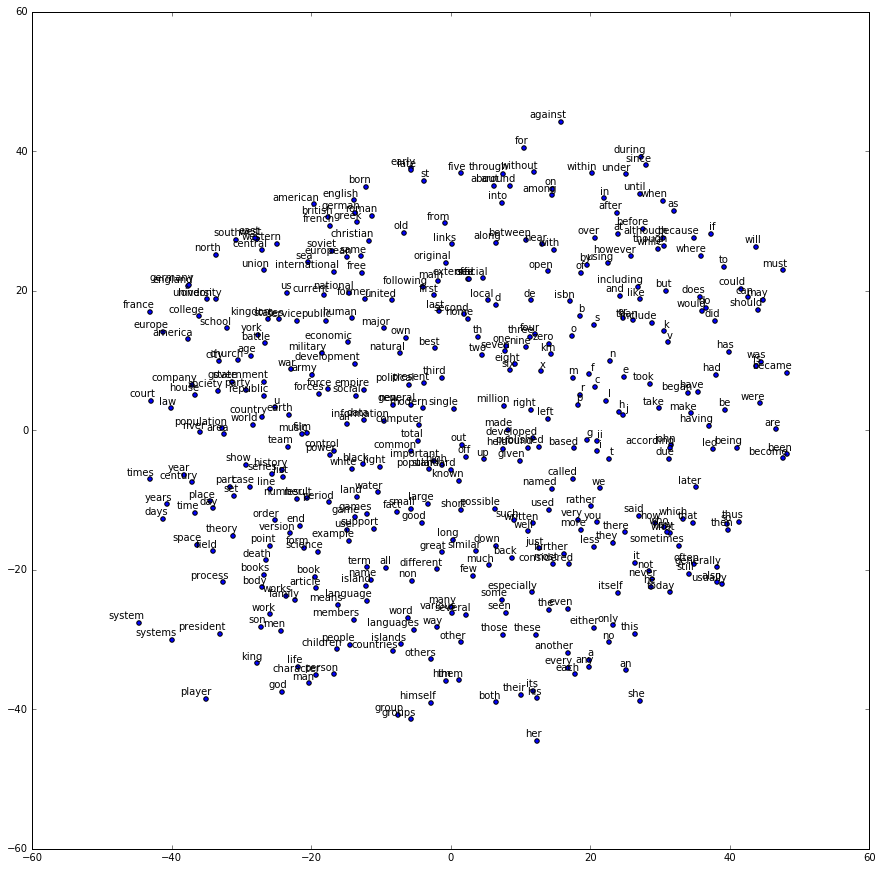

In [23]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to Word2Vec is called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

Some context from the [TensorFlow web page](https://www.tensorflow.org/versions/master/tutorials/word2vec/index.html):

"Word2vec is a particularly computationally-efficient predictive model for learning word embeddings from raw text. It comes in two flavors, the Continuous Bag-of-Words model (CBOW) and the Skip-Gram model. Algorithmically, these models are similar, except that CBOW predicts target words (e.g. 'mat') from source context words ('the cat sits on the'), while the skip-gram does the inverse and predicts source context-words from the target words. This inversion might seem like an arbitrary choice, but statistically it has the effect that CBOW smoothes over a lot of the distributional information (by treating an entire context as one observation). For the most part, this turns out to be a useful thing for smaller datasets. However, skip-gram treats each context-target pair as a new observation, and this tends to do better when we have larger datasets."

There is a nice discussion of CBOW and skip-gram, at a high level, on the [TensorFlow word2vec tutorial page](https://www.tensorflow.org/versions/master/tutorials/word2vec/index.html) refernced above. The key thing to understand about CBOW vs skip-gram is that CBOW is attempting to predict a word from the surrounding context, while skip-gram is attempting to do the opposite - given a target word, it attempts to predict surrounding context.

Their illustration is nice. Consider:

    the quick brown fox jumped over the lazy dog
    
If we consider a context window that is one word wide, the `([context], target)` pairing CBOW wants to use is:

    ([the, brown], quick), ([quick, fox], brown), ([brown, jumped], fox), ([fox, over], jumped), etc.
    
In fact, what CBOW wants to do (?) is average the words in the context vector. Skip-gram, by contrast, wants to invert this data and use target to predict the context in pairs like `(target, context)`:

    (quick, the), (quick, brown), (brown, quick), (brown, fox), (fox, brown), (fox, jumped), (jumped, fox), etc.

In [24]:
rawdata = 'the quick brown fox jumped over the lazy dog'.split()
print rawdata
print len(rawdata)

['the', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy', 'dog']
9


In [25]:
window_wing = 1
window_size = 2 * window_wing + 1
window_center_idx = window_size // 2
first_idx = window_center_idx
last_idx = len(rawdata) - window_wing

data = []
for i in range(first_idx, last_idx):
    print i, rawdata[i]
    window = rawdata[i - window_wing: 1 + i + window_wing]
    print window
    target = window[window_center_idx]
    context = window[0:window_center_idx] + window[window_center_idx + 1:]
    val = (context, target)
    data.append(val)
    
print data

1 quick
['the', 'quick', 'brown']
2 brown
['quick', 'brown', 'fox']
3 fox
['brown', 'fox', 'jumped']
4 jumped
['fox', 'jumped', 'over']
5 over
['jumped', 'over', 'the']
6 the
['over', 'the', 'lazy']
7 lazy
['the', 'lazy', 'dog']
[(['the', 'brown'], 'quick'), (['quick', 'fox'], 'brown'), (['brown', 'jumped'], 'fox'), (['fox', 'over'], 'jumped'), (['jumped', 'the'], 'over'), (['over', 'lazy'], 'the'), (['the', 'dog'], 'lazy')]


In [26]:
def make_data(window_wing, rawdata):
    window_size = 2 * window_wing + 1
    window_center_idx = window_size // 2
    first_idx = window_center_idx
    last_idx = len(rawdata) - window_wing
    
    data = []
    contexts = []
    targets = []
    for i in range(first_idx, last_idx):
        window = rawdata[i - window_wing: 1 + i + window_wing]
        target = window[window_center_idx]
        context = window[0:window_center_idx] + window[window_center_idx + 1:]
        val = (context, target)
        data.append(val)
        contexts.append(context)
        targets.append(target)
        
    return data, contexts, targets

In [27]:
data, contexts, targets = make_data(1, rawdata)
print data
print contexts
print targets

[(['the', 'brown'], 'quick'), (['quick', 'fox'], 'brown'), (['brown', 'jumped'], 'fox'), (['fox', 'over'], 'jumped'), (['jumped', 'the'], 'over'), (['over', 'lazy'], 'the'), (['the', 'dog'], 'lazy')]
[['the', 'brown'], ['quick', 'fox'], ['brown', 'jumped'], ['fox', 'over'], ['jumped', 'the'], ['over', 'lazy'], ['the', 'dog']]
['quick', 'brown', 'fox', 'jumped', 'over', 'the', 'lazy']


In [28]:
data, contexts, targets = make_data(2, rawdata)
print data
print contexts
print targets

[(['the', 'quick', 'fox', 'jumped'], 'brown'), (['quick', 'brown', 'jumped', 'over'], 'fox'), (['brown', 'fox', 'over', 'the'], 'jumped'), (['fox', 'jumped', 'the', 'lazy'], 'over'), (['jumped', 'over', 'lazy', 'dog'], 'the')]
[['the', 'quick', 'fox', 'jumped'], ['quick', 'brown', 'jumped', 'over'], ['brown', 'fox', 'over', 'the'], ['fox', 'jumped', 'the', 'lazy'], ['jumped', 'over', 'lazy', 'dog']]
['brown', 'fox', 'jumped', 'over', 'the']


Let's get some fresh data to test:

In [29]:
# recall, `vocabulary_size` is a **global** that `build_dataset()` accesses

filename = maybe_download('text8.zip', 31344016)
vocabulary_size = 50000

#filename = maybe_download('mytesttext.txt.zip', 415)   # of course, this file is local
#vocabulary_size = 30

words = read_data(filename)
print('Data size %d' % len(words))

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:10])
print(len(count))
print(len(dictionary))
del words  # Hint to reduce memory.

Found and verified text8.zip
['text8']
Data size 17005207
('Most common words (+UNK)', [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764), ('in', 372201), ('a', 325873), ('to', 316376), ('zero', 264975), ('nine', 250430)])
50000
50000


In [30]:
print('rev dict sample keys  :', reverse_dictionary.keys()[:20])
print('rev dict sample values:', reverse_dictionary.values()[:20])

('rev dict sample keys  :', [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
('rev dict sample values:', ['UNK', 'the', 'of', 'and', 'one', 'in', 'a', 'to', 'zero', 'nine', 'two', 'is', 'as', 'eight', 'for', 's', 'five', 'three', 'was', 'by'])


In [31]:
for d in data[:10]:
    print '{:08d}, {}'.format(d, reverse_dictionary[d])

00005239, anarchism
00003084, originated
00000012, as
00000006, a
00000195, term
00000002, of
00003137, abuse
00000046, first
00000059, used
00000156, against


Let's redefine our `make_data()` function as `generate_batch()` and keep track of the global `data_index`:

In [32]:
data_index = 0

In [33]:
def generate_batch(batch_size, window_wing):
    # let's keep track of where we are in the data
    global data_index
    # how much data do we span per batch?
    window_size = 2 * window_wing + 1
    window_center_idx = window_size // 2
    # batch is context, labels are targets
    batch = np.zeros(shape=(batch_size, 2 * window_wing), dtype=np.int32)
    labels = np.zeros(shape=(batch_size, 1), dtype=np.int32)
    # hold the data for the minibatch
    buffer = collections.deque(maxlen=window_size)
    # indices for context
    ctx_indices = np.arange(window_size)
    ctx_indices = np.delete(ctx_indices, window_center_idx)
    # initialize the buffer with the next `span` words of data
    for _ in range(window_size):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size):
        target = buffer[window_center_idx]
        context = []
        for idx in ctx_indices:
            context.append(buffer[idx])
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
        batch[i] = context
        labels[i] = target
        
    #return batch, labels   # first guess
    return np.mean(batch, axis=1), labels

In [34]:
data_index = 0
batch_size = 8
print('data:', [reverse_dictionary[di] for di in data[:batch_size]])
for wing in [1, 2]:
    data_index = 0
    batch, labels = generate_batch(batch_size=batch_size, window_wing=wing)
    print('\nwith window_wing = %d:' % wing)
#1st guess    print('    batch:', [[reverse_dictionary[i] for i in bi] for bi in batch])
#1st guess    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(batch_size)])
#1st guess    print('    batch:', [[i for i in bi] for bi in batch])
#1st guess    print('    labels:', [li for li in labels.reshape(batch_size)])
    print('    batch:', batch)
    print('    labels:', labels)

('data:', ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first'])

with window_wing = 1:
('    batch:', array([ 2625.5,  1545. ,   103.5,     4. ,  1666. ,    24. ,  1598. ,
         101. ]))
('    labels:', array([[3084],
       [  12],
       [   6],
       [ 195],
       [   2],
       [3137],
       [  46],
       [  59]], dtype=int32))

with window_wing = 2:
('    batch:', array([ 2131.  ,   823.25,   789.25,   846.  ,    75.5 ,   838.5 ,
         866.75,   243.75]))
('    labels:', array([[  12],
       [   6],
       [ 195],
       [   2],
       [3137],
       [  46],
       [  59],
       [ 156]], dtype=int32))


In [35]:
sess = tf.InteractiveSession()

In [36]:
vsize, esize = 6, 3

# make a test embeddings matrix
a = tf.random_uniform([vsize, esize], 0.0, 1.0).eval(session=sess)
print np.shape(a)
print a
print '\n'

# get elems 
get_elems = [[0, 3, 5], [1, 2, 4]]   # shp = number of batches, embed size 
print np.shape(get_elems)
b = tf.nn.embedding_lookup(a, get_elems).eval(session=sess)
print np.shape(b)
print b
print '\n'

# do an average
b = tf.reduce_mean(b, reduction_indices=1).eval(session=sess)   # np.mean(b, axis=1)
print np.shape(b)
print b
print '\n'

(6, 3)
[[ 0.60012019  0.40938282  0.25230813]
 [ 0.72147274  0.93523693  0.32026577]
 [ 0.8434552   0.97550261  0.04216921]
 [ 0.7490176   0.5888418   0.30148757]
 [ 0.60256219  0.8994453   0.70996988]
 [ 0.42291903  0.46260726  0.98945987]]


(2, 3)
(2, 3, 3)
[[[ 0.60012019  0.40938282  0.25230813]
  [ 0.7490176   0.5888418   0.30148757]
  [ 0.42291903  0.46260726  0.98945987]]

 [[ 0.72147274  0.93523693  0.32026577]
  [ 0.8434552   0.97550261  0.04216921]
  [ 0.60256219  0.8994453   0.70996988]]]


(2, 3)
[[ 0.59068561  0.48694396  0.51441854]
 [ 0.72249669  0.9367283   0.35746828]]




In [38]:
# vocabulary_size, embedding_size = 30, 6
embedding_size = 128
window_wing = 1

# valid_size = 3
# valid_window = 10
# valid_examples = np.array(random.sample(range(valid_window), valid_size))
# num_sampled = 5

valid_size = 16    # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64   # Number of negative examples to sample.

batch_size = 128
data_index = 0
print valid_examples
print np.shape(valid_examples)

[19 89  7 84 90 33 82 75 66 52 64 71 50 15 95 46]
(16,)


In [39]:
# Input data
#train_dataset = tf.placeholder(tf.int32, shape=[batch_size, 2 * window_wing], name="test_train_dset")
train_dataset = tf.placeholder(tf.int32, shape=[batch_size], name="test_train_dset")
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1], name="test_train_labels")
valid_dataset = tf.constant(valid_examples, dtype=tf.int32, name="test_valid_dset")

In [40]:
# Variables
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0), name='test_embeddings')
softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                                                 stddev=1.0 / math.sqrt(embedding_size)),
                             name='test_softmax_weights')
softmax_biases = tf.Variable(tf.zeros([vocabulary_size]),
                            name='test_softmax_biases')

In [41]:
#embed0 = tf.nn.embedding_lookup(embeddings, train_dataset)
#embed = tf.reduce_mean(embed0, reduction_indices=1)

embed = tf.nn.embedding_lookup(embeddings, train_dataset)

In [42]:
l1 = tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed, train_labels, num_sampled, vocabulary_size)
loss = tf.reduce_mean(l1)

optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

In [43]:
init_op = tf.initialize_all_variables()
sess.run(init_op)

batch_data, batch_labels = generate_batch(batch_size, window_wing)
feed_dict = {train_dataset : batch_data, train_labels : batch_labels}

# 1st guess
#sess.run(tf.shape(
#        embed0
#    ), feed_dict=feed_dict)

In [44]:
sess.run(tf.shape(
        embed
    ), feed_dict=feed_dict)

array([128, 128], dtype=int32)

In [45]:
sess.run(tf.shape(
        l1
    ), feed_dict=feed_dict)

array([128], dtype=int32)

In [46]:
sess.run(tf.shape(
        loss
    ), feed_dict=feed_dict)

array([], dtype=int32)

In [47]:
sess.run(tf.reduce_mean(l1), feed_dict=feed_dict)

7.6040082

In [48]:
# use with test data
graph = tf.Graph()

with graph.as_default():

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    #1st guess: train_dataset = tf.placeholder(tf.int32, shape=[batch_size, 2 * window_wing])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
    # Variables.
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], 
                                                      stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
    # Model.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    #1st guess: embed = tf.reduce_mean(embed, reduction_indices=1)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(softmax_weights, 
                                                     softmax_biases, 
                                                     embed, 
                                                     train_labels, 
                                                     num_sampled, 
                                                     vocabulary_size))

    # Optimizer.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [50]:
num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(batch_size, window_wing)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in xrange(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in xrange(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.053325
Nearest to by: ides, ul, unjustified, seamus, dominate, nigerian, praia, anglia,
Nearest to called: accede, interstitial, engine, mehrgarh, inexorably, gnu, kristallnacht, zionist,
Nearest to to: redistribute, jiva, how, exaggerate, optional, aromatherapy, chills, aai,
Nearest to war: retold, lyons, doorway, daughters, gob, cripps, baton, angiotensin,
Nearest to use: plagiarism, soldiers, nucleosynthesis, bugzilla, logico, cotswolds, aelia, drachma,
Nearest to this: disappearance, entrusted, counternarcotics, lineman, occasioned, stronghold, provides, kinases,
Nearest to states: forgiveness, maclennan, lpc, demonstrating, champions, zawahiri, carrot, datatype,
Nearest to d: aes, aneurin, cohabitation, pellet, mortis, welsh, louvre, samael,
Nearest to these: whigs, economical, shan, victim, interview, dervish, loved, ly,
Nearest to most: peek, js, shall, sceptical, aardwolf, nickel, monazite, llewellyn,
Nearest to american: octave, veto, circ

In [51]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

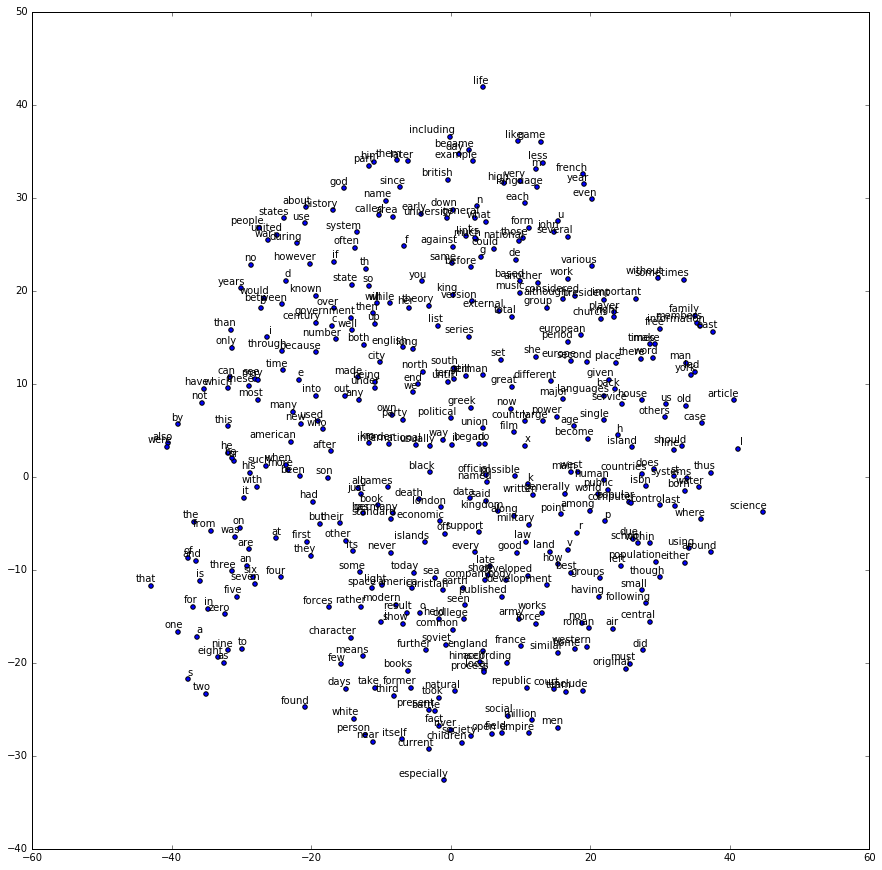

In [52]:
words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)